In [238]:
from system import *
import matplotlib.pyplot as plt
import time
import pickle
from scipy.integrate import solve_ivp
import autograd.numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_continuous_lyapunov
from autograd import jacobian
import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm import tqdm


np.random.seed(232)

In [239]:
def add_arrow(line, position=None, direction='right', size=15, color=None):
    """
    add an arrow to a line.

    line:       Line2D object
    position:   x-position of the arrow. If None, mean of xdata is taken
    direction:  'left' or 'right'
    size:       size of the arrow in fontsize points
    color:      if None, line color is taken.
    """
    if color is None:
        color = line.get_color()

    xdata = line.get_xdata()
    ydata = line.get_ydata()

    if position is None:
        position = xdata.mean()
    # find closest index
    start_ind = np.argmin(np.absolute(xdata - position))
    if direction == 'right':
        end_ind = start_ind + 1
    else:
        end_ind = start_ind - 1

    line.axes.annotate('',
        xytext=(xdata[start_ind], ydata[start_ind]),
        xy=(xdata[end_ind], ydata[end_ind]),
        arrowprops=dict(arrowstyle="-|>", color=color),
        size=size
    )

In [240]:
alpha = 10
phi = lambda x: alpha * np.tanh(x)
f = lambda x: 1 / tau * (-x + phi(W@x + theta))

jacobian_ = jacobian(f)
A = jacobian_(np.zeros(2))

solve_continuous_lyapunov(A, np.eye(A.shape[0]))

array([[28.87148764, -0.24603108],
       [-0.24603108, 29.22897575]])

In [241]:
def dynam(x, dt):
    return dt * f(x) + x

def simulate(x0, dt, T):
    t = [0]
    ret = [x0]
    while t[-1] < T:
        t.append(t[-1] + dt)
        ret.append(dynam(ret[-1], dt))
    
    return t, ret
        

def section(x):
    addend = 0
    if x[0] < 0:
        addend = 1
    return abs(x[1]) + addend # lies on positive x axis

def pmap(x, dt=0.001):
    left = False
    T = 0
    while True:
        x = dynam(x, dt)
        T += dt
        if not np.isclose(section(x), 0, atol=0.001):
            left = True
        elif left and np.isclose(section(x), 0, atol=0.001):
            break
    return x, abs(T)

In [254]:
x = np.array([4,0])
x_, T = pmap(x, dt=0.001)
x,T

(array([4, 0]), 11.22299999999922)

In [255]:
convergence = []
try:
    for i in range(70):
        x, _ = pmap(np.array(x))
        print(x, end='                       \r')
        convergence.append(x)
finally:
    convergence = np.array(convergence)


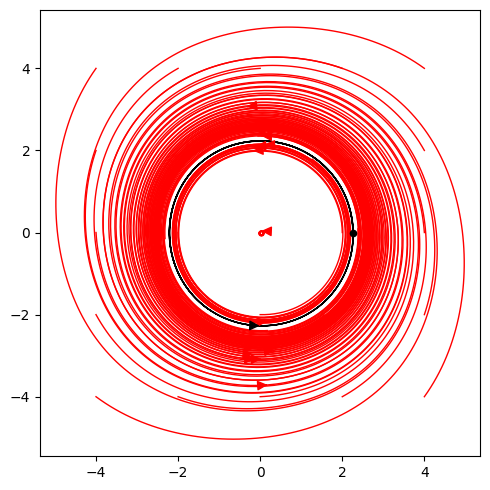

In [256]:
fig, ax = plt.subplots()
ax.scatter(2.26, 0, s=20, color='black', zorder=1)

X0 = []
NUM = 5
BOUND = 4
for a in np.linspace(-BOUND, BOUND, num=NUM):
    for b in np.linspace(-BOUND, BOUND, num=NUM):
        X0.append((a,b))

X0.append((2.26,0))
# for a in np.linspace(-0.8, 0.8, num=3):
#     for b in np.linspace(-0.8, 0.8, num=3):
#         X0.append((a,b))
W = weight_matrix
theta = bias_matrix
alpha = 10
phi = lambda x: alpha * np.tanh(x)
g = lambda t, x: 1 / tau * (-x + phi(W@x + theta))

for x0 in X0:
    t_eval = np.arange(0, 40, 0.05)
    sol = solve_ivp(g, t_span=[0, 40], y0=x0, t_eval=t_eval)
    color = 'red'
    if x0 == (2.26, 0):
        color = 'black'
    l, = ax.plot(sol.y[0], sol.y[1], label='x(t)', color=color, lw=1, zorder=0)
    ax.set_aspect('equal', adjustable='datalim')
    add_arrow(l)

fig.set_size_inches((5, 5))
plt.tight_layout()
plt.savefig('/Users/neiljanwani/Documents/CDS232/src/project/graphs/orbit_shown.png', dpi=500)

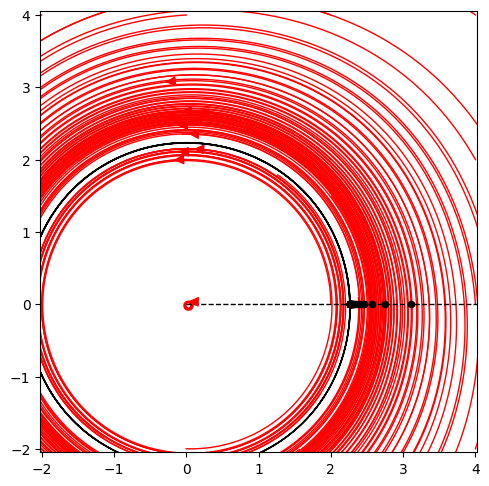

In [257]:
fig, ax = plt.subplots()
ax.scatter(convergence[:,0], convergence[:, 1], s=20, color='black', zorder=1)
ax.set_ylim((-2, 4))
ax.set_xlim((-2,4))
ax.plot([0, 20], [0,0], lw=1, linestyle='--', color='black')



X0 = []
NUM = 5
BOUND = 4
for a in np.linspace(-BOUND, BOUND, num=NUM):
    for b in np.linspace(-BOUND, BOUND, num=NUM):
        X0.append((a,b))

X0.append((2.26,0))
# for a in np.linspace(-0.8, 0.8, num=3):
#     for b in np.linspace(-0.8, 0.8, num=3):
#         X0.append((a,b))
W = weight_matrix
theta = bias_matrix
alpha = 10
phi = lambda x: alpha * np.tanh(x)
g = lambda t, x: 1 / tau * (-x + phi(W@x + theta))

for x0 in X0:
    t_eval = np.arange(0, 40, 0.05)
    sol = solve_ivp(g, t_span=[0, 40], y0=x0, t_eval=t_eval)
    color = 'red'
    if x0 == (2.26, 0):
        color = 'black'
    l, = ax.plot(sol.y[0], sol.y[1], label='x(t)', color=color, lw=1, zorder=0)
    ax.set_aspect('equal', adjustable='datalim')
    add_arrow(l)

fig.set_size_inches((5, 5))
plt.tight_layout()
plt.savefig('/Users/neiljanwani/Documents/CDS232/src/project/graphs/poincare_section', dpi=500)

In [253]:
convergences = []
for x0 in tqdm(X0[:len(X0)//2], disable=False):
    x = np.array(x0)
    conv = []
    last = 0
    bruh = np.array([0, x[0], x[1]])
    conv.append(bruh)
    for _ in range(10):
        x, T = pmap(np.array(x), dt=0.01)
        bruh = np.array([T + last, x[0], x[1]])
        last += T
        # print(T, end='                       \r')
        conv.append(bruh)
        
    convergences.append(conv)

convergences = np.array(convergences)
print(len(convergences))

100%|██████████| 13/13 [00:13<00:00,  1.02s/it]

13


[  0.   114.77 246.47 345.24 367.19 465.96 487.91 586.68 685.45 707.4
 806.17]
[  0.   126.1  213.9  235.85 334.62 433.39 455.34 554.11 652.88 674.83
 773.6 ]
[  0.    16.81  60.9   82.87  93.85 214.58 236.53 335.3  357.25 456.02
 554.79]
[  0.   105.71 259.36 281.31 380.08 478.85 500.8  599.57 698.34 720.29
 819.06]
[  0.    29.53  51.58 249.19 271.14 369.91 468.68 490.63 589.4  688.17
 710.12]
[  0.    37.04  70.04 146.89 168.84 289.56 388.33 410.28 509.05 607.82
 629.77]
[  0.   125.07 245.79 267.74 366.51 465.28 487.23 586.   684.77 706.72
 805.49]
[  0.    38.34 180.97 279.74 378.51 400.46 499.23 598.   619.95 718.72
 817.49]
[  0.     6.92 127.78 149.73 270.45 369.22 391.17 489.94 588.71 610.66
 709.43]
[  0.    29.91 128.82 194.67 216.62 315.39 337.34 436.11 534.88 556.83
 655.6 ]
[  0.    69.14 113.06 200.86 222.81 321.58 343.53 442.3  541.07 563.02
 661.79]
[  0.    46.56  68.49  90.43 156.27 255.04 353.81 375.76 474.53 573.3
 595.25]
[  0.     7.19  17.8   28.45  39.13  49.82

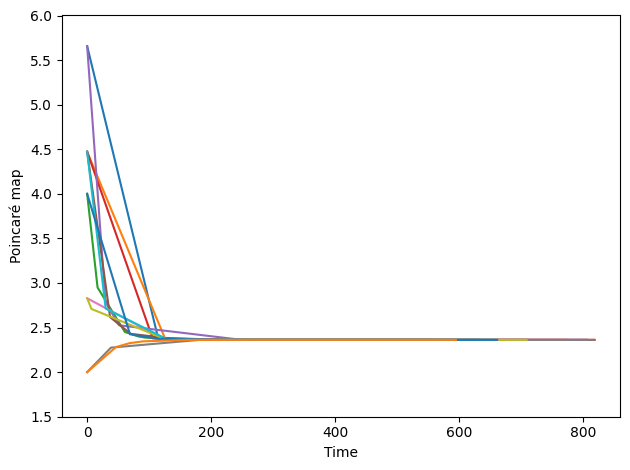

In [247]:
fig, ax = plt.subplots()
for conv in convergences:
    print(conv[:, 0])
    ax.plot(conv[:, 0], np.linalg.norm(conv[:,1:], axis=1))

ax.set_xlabel('Time')
ax.set_ylabel('Poincaré map')
    
ax.set_ylim((1.5, 6))
# ax.set_xlim((-1, 15))
fig.tight_layout()
plt.savefig('/Users/neiljanwani/Documents/CDS232/src/project/graphs/Poincare_converege', dpi=500)

In [248]:
jacobian_ = jacobian(lambda x: pmap(x)[0])
A = jacobian_(x)
A

array([[ 1.1960887 ,  0.01672485],
       [-0.0215244 ,  1.20163155]])

In [249]:
np.linalg.eig(A)

(array([1.19886013+0.01876996j, 1.19886013-0.01876996j]),
 array([[-0.09658862+0.65416368j, -0.09658862-0.65416368j],
        [-0.75016033+0.j        , -0.75016033-0.j        ]]))

In [250]:
t, pts = simulate(np.array([2,2]), 0.001, 0.5)
pts = np.array(pts)
np.gradient(pts)

[array([[-0.00114794,  0.00109687],
        [-0.00114826,  0.00109652],
        [-0.0011489 ,  0.00109583],
        ...,
        [-0.00141746,  0.0007212 ],
        [-0.0014179 ,  0.0007204 ],
        [-0.00141811,  0.00071999]]),
 array([[0.        , 0.        ],
        [0.00224481, 0.00224481],
        [0.00448957, 0.00448957],
        ...,
        [1.09801977, 1.09801977],
        [1.10015825, 1.10015825],
        [1.10229635, 1.10229635]])]

In [223]:
import pickle

pickle_file_path = r'/Users/neiljanwani/Documents/CDS232/src/periodic_pickles/stable_A_alpha10.pickle' #r'/Users/neiljanwani/Documents/CDS232/src/periodic_pickles/circle_A.pickle'
with open(pickle_file_path, 'rb') as file:
    weight_matrix = pickle.load(file)
pickle_file_path = r'/Users/neiljanwani/Documents/CDS232/src/periodic_pickles/stable_b_alpha10.pickle' #r'/Users/neiljanwani/Documents/CDS232/src/periodic_pickles/circle_B.pickle'
with open(pickle_file_path, 'rb') as file:
    bias_matrix = pickle.load(file)
    

W = weight_matrix
theta = bias_matrix
plot2D = True
tau = 1.0

phi = lambda x: alpha * np.tanh(x)
f = lambda x: 1 / tau * (-x + phi(W@x + theta))

In [225]:
jacobian_ = jacobian(f)
A = jacobian_(np.zeros(2))
print('A', A)
Q = np.eye(2)
P = solve_continuous_lyapunov(A.T, -Q)
print('P', P)
print(np.linalg.eig(P)[0])
np.allclose(A.T@P + P@A + Q, np.zeros(2))


A [[-0.87719468  0.48042368]
 [-0.48038121 -0.87721182]]
P [[5.69991800e-01 1.29610136e-05]
 [1.29610136e-05 5.69994855e-01]]
[0.56998028 0.57000638]


True

In [209]:
A

array([[-0.87719468,  0.48042368],
       [-0.48038121, -0.87721182]])

100%|██████████| 50/50 [00:24<00:00,  2.03it/s]


1000.0 0.6780685644669119


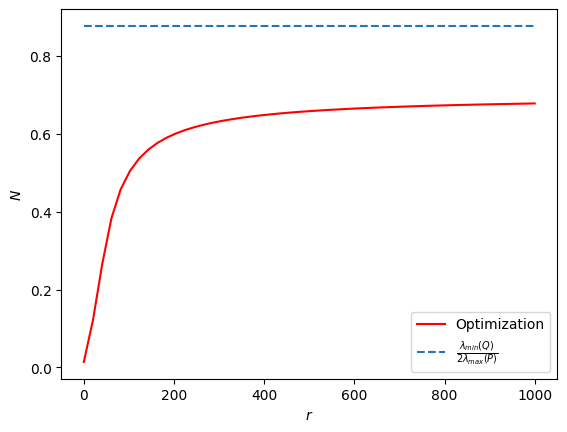

In [237]:

def integrate(func, a, b, axis=0, dt=0.01):
    if a == b:
        return np.zeros(x.shape[1])
    t = np.linspace(a, b, num=int((b - a) / dt))
    # print(func(t[0]))
    fs = [func(t_) for t_ in t]
    # print(dt)
    return np.trapz(fs, dx=dt, axis=0)

def inside(v):
    func = lambda tau: jacobian_(tau * v)
    integral = integrate(func, 0, 1)
    return np.linalg.norm(integral - jacobian_(np.zeros(2)))

bigmax = -np.inf
bigr = -np.inf
rs = []
maxs = []
for r in tqdm(np.linspace(0, 1000, num=50)):
    thetas = np.linspace(0, 2*np.pi)
    vecs = np.array([r * np.cos(thetas), r * np.sin(thetas)]).T
    maximum = -np.inf
    for idx in range(vecs.shape[0]):
        val = inside(vecs[idx,:])
        if val > maximum:
            maximum = val

    if maximum > bigmax:
        bigmax = maximum
        bigr = r
        
    rs.append(r)
    maxs.append(maximum)
    
fig, ax = plt.subplots()
print(bigr, bigmax)
ax.plot(rs, maxs, color='red', label='Optimization')
ax.set_xlabel('$r$')
ax.set_ylabel('$N$')
ax.plot([rs[0], rs[-1]], [np.min(np.linalg.eig(Q)[0]) / (2 * np.max(np.linalg.eig(P)[0]))] *2, linestyle='--', label=r'$\frac{\lambda_{min}(Q)}{2\lambda_{max}(P)}$')
ax.legend()
plt.savefig('/Users/neiljanwani/Documents/CDS232/src/project/graphs/DofA', dpi=500)

In [116]:
np.min(np.linalg.eig(Q)[0]) / (2 * np.max(np.linalg.eig(P)[0]))

0.8771831665395494

In [39]:
np.linalg.eig(P)[0]

array([-0.57000638, -0.56998028])

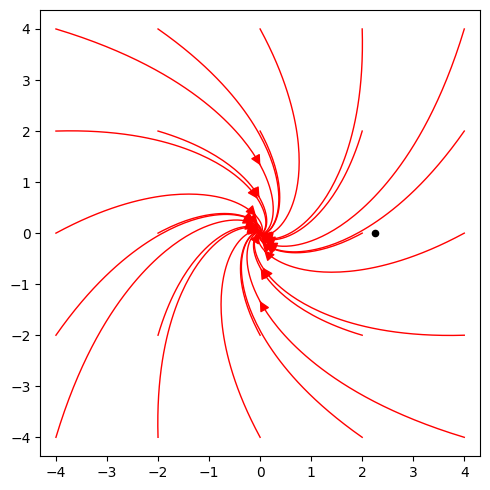

In [40]:
fig, ax = plt.subplots()
ax.scatter(2.26, 0, s=20, color='black', zorder=1)

X0 = []
NUM = 5
BOUND = 4
for a in np.linspace(-BOUND, BOUND, num=NUM):
    for b in np.linspace(-BOUND, BOUND, num=NUM):
        X0.append((a,b))

# X0.append((2.26,0))
# for a in np.linspace(-0.8, 0.8, num=3):
#     for b in np.linspace(-0.8, 0.8, num=3):
#         X0.append((a,b))
W = weight_matrix
theta = bias_matrix
alpha = 10
phi = lambda x: alpha * np.tanh(x)
g = lambda t, x: 1 / tau * (-x + phi(W@x + theta))

for x0 in X0:
    t_eval = np.arange(0, 40, 0.05)
    sol = solve_ivp(g, t_span=[0, 40], y0=x0, t_eval=t_eval)
    color = 'red'
    if x0 == (2.26, 0):
        color = 'black'
    l, = ax.plot(sol.y[0], sol.y[1], label='x(t)', color=color, lw=1, zorder=0)
    ax.set_aspect('equal', adjustable='datalim')
    add_arrow(l)

fig.set_size_inches((5, 5))
plt.tight_layout()
# plt.savefig('/Users/neiljanwani/Documents/CDS232/src/project/graphs/orbit_shown.png', dpi=500)

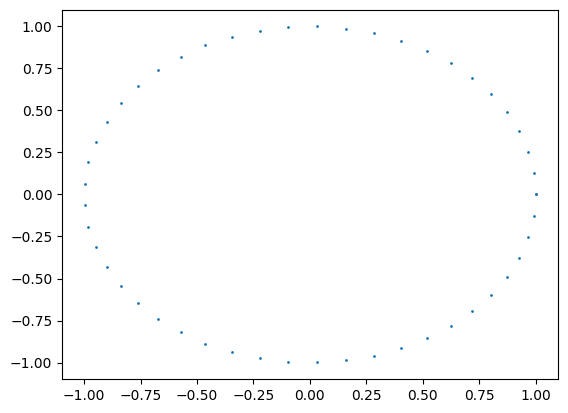

In [153]:
r, theta = 1, np.linspace(0,2*np.pi)
# for 

vecs = np.array([r * np.cos(theta), r * np.sin(theta)]).T
plt.scatter(vecs[:,0], vecs[:, 1], s=1)
plt.show()

In [77]:
print(np.linalg.eig(x)[0])

[-0.57000638 -0.56998028]


In [55]:
np.linalg.eig(a)

(array([-1.        , -0.26794919, -3.73205081]),
 array([[ 0.        , -0.10545772,  0.7948773 ],
        [ 0.        ,  0.14405793,  0.29094528],
        [ 1.        , -0.98393393,  0.53246683]]))